# Опис файлів:
DWH.db - SQLite база даних, яка містить необхідні для завдання дані<br>
city_dict.txt – довідник населених пунктів

1) Напишіть конектор до бази даних DWH.db (SQLite) (файл в архіві разом із завданням)

In [62]:
import sqlite3

try:
    connection = sqlite3.connect('DWH.db')
    print("Successfully connected!")

except sqlite3.Error as error:
    print("Error while connecting to sqlite", error)

Successfully connected!


2) За допомогою sql-запиту виведіть список таблиць, які містяться в БД

In [63]:
try:
    cursor = connection.cursor()
    all_tables_query = "SELECT name FROM sqlite_master WHERE type ='table' AND name NOT LIKE 'sqlite_%';"
    cursor.execute(all_tables_query)
    result = cursor.fetchall()
    print("List of name of tables:", result)
    cursor.close()
except sqlite3.Error as error:
    print("Invalid!", error)

List of name of tables: [('keys_vector',), ('msc_types',), ('subscriber_types',), ('events',)]


# Опис полів
<b>table.events</b><br>
subs_id - ідентифікатор вихідного абонента<br>
subs_type - тип вихідного абонента<br>
call_time - час дзвінка<br>
call_duration_seconds - тривалість дзвінка в секундах<br>
switch_id - ідентифікатор комутатора, що обслуговує дзвінок<br>
from_number - вихідний номер<br>
to_number - вхідний номер<br>
cell_id - сота базової станції, де знаходився вихідний номер під час дзвінка<br>
city_id - ідентифікатор міста проживання вихідного абонента<br>

<b>table.subscriber_types</b><br>
subs_type - тип абонента<br>
marketing_group - приналежність номера до маркетингової категорії - передоплата чи контракт<br>

<b>table.msc_types</b><br>
switch_id - ідентифікатор комутатора<br>
switch_name - назва комутатора<br>
switch_vendor - вендор комутатора<br>

3) Виконайте sql-запит до БД і вивантажте суму тривалості дзвінків в хвилинах у порядку зменшення (TOP20) за кожним вихідним номером, який не починається на 827 та має більше ніж 7 символів

In [64]:
try:
    cursor = connection.cursor()
    query = "SELECT ROUND(SUM(call_duration_seconds)/60.0, 3) as sum_time_min \
                        FROM events \
                        WHERE  from_number NOT LIKE '827%' AND length(from_number)>7\
                        GROUP BY from_number\
                        ORDER BY sum_time_min DESC\
                        LIMIT 20;"
    cursor.execute(query)
    result = cursor.fetchall()
    print("Sum of calls in min (TOP20):", result)
    cursor.close()
except sqlite3.Error as error:
    print("Invalid!", error)

Sum of calls in min (TOP20): [(120.05,), (120.05,), (120.033,), (120.033,), (120.033,), (120.033,), (118.533,), (102.817,), (98.383,), (95.8,), (93.183,), (92.533,), (89.017,), (88.95,), (85.45,), (84.35,), (74.617,), (74.583,), (74.55,), (73.833,)]


4) Виконайте sql-запит до БД і вивантажте назви та вендори комутаторів, які мають кількість дзвінків більшу ніж 1000 але меншу ніж 24378 відсортувавши за спаданням кількості дзвінків.<br>
Додатково, по результатам запиту, відпринтуйте назву та вендора комутатора, який має найбільшу кількість дзвінків

In [65]:
try:
    cursor = connection.cursor()
    query = "SELECT msc_types.switch_name, msc_types.switch_vendor \
                        FROM msc_types LEFT JOIN events ON msc_types.switch_id = events.switch_id\
                        GROUP BY msc_types.switch_id\
                        HAVING COUNT(events.subs_id) BETWEEN 1000 AND 24378\
                        ORDER BY COUNT(events.subs_id) DESC;"
    cursor.execute(query)
    result = cursor.fetchall()
    print("Names and vendors of commutators:", result)
    print("TOP1 name and vendor of commutator:", result[0])
    cursor.close()
except sqlite3.Error as error:
    print("Invalid!", error)

Names and vendors of commutators: [('MSC-403', 'Ericsson'), ('MSC-404', 'Ericsson'), ('MSC-406', 'Ericsson'), ('MSC-405', 'Ericsson'), ('MSC-402', 'Ericsson'), ('MSC-408', 'Ericsson'), ('MSC-401', 'Ericsson'), ('MSC-407', 'Ericsson'), ('MSC-413', 'Ericsson'), ('MSC-411', 'Ericsson')]
TOP1 name and vendor of commutator: ('MSC-403', 'Ericsson')


5) Виконайте sql-запит до БД і вивантажте в змінну df_1215 (pandas.DataFrame) усі дзвінки за 3 вересня 2019 року в період 12:00:00 - 20:59:59, а також збагатіть вивантаження полем marketing_group

In [66]:
import pandas as pd
try:
    cursor = connection.cursor()
    query = "SELECT events.*, marketing_group \
                        FROM events LEFT JOIN subscriber_types ON events.subs_type = subscriber_types.subs_type\
                        WHERE call_time BETWEEN '2019-09-03 12:00:00' AND '2019-09-03 20:59:59';"
    cursor.execute(query)
    result = cursor.fetchall()
    col = list(map(lambda x: x[0], cursor.description))
    df_1215 = pd.DataFrame(result, columns = col)
    cursor.close()
except sqlite3.Error as error:
    print("Invalid!", error)

In [67]:
df_1215.head()

,subs_id,subs_type,call_time,call_duration_seconds,switch_id,from_number,to_number,cell_id,city_id,marketing_group
0,60358,1,2019-09-03 14:10:57.000000,170,P2HAQN,None,800965962835,3332427526,None,postpaid
1,61551,1,2019-09-03 14:06:59.000000,96,P2HAQN,None,650138584593,3332427526,None,postpaid
2,62820,1,2019-09-03 13:58:22.000000,74,VL8EB0,840980388592,41601395865564,3332427526,None,postpaid
3,67750,1,2019-09-03 14:25:41.000000,126,VL8EB0,840980388592,92054021488914,3332427526,None,postpaid
4,122688,1,2019-09-03 13:26:14.000000,194,VL8EB0,840980388592,44843162364902,3332427526,None,postpaid


6) Підвантажте довідник міст city_dict.txt (файл в архіві разом із завданням)

In [68]:
df_city_dict = pd.read_table('city_dict.txt', sep = '\t', encoding = 'windows-1251')

7) Збагатіть датафрейм df_1215 полем city_name із довідника, що підвантажили раніше

In [69]:
df_1215['city_id'] = df_1215['city_id'].astype(float)
df_1215_city = df_1215.merge(df_city_dict, how = 'left', on = 'city_id')
df_1215_city.head()

,subs_id,subs_type,call_time,call_duration_seconds,switch_id,from_number,to_number,cell_id,city_id,marketing_group,city_name
0,60358,1,2019-09-03 14:10:57.000000,170,P2HAQN,None,800965962835,3332427526,NaN,postpaid,NaN
1,61551,1,2019-09-03 14:06:59.000000,96,P2HAQN,None,650138584593,3332427526,NaN,postpaid,NaN
2,62820,1,2019-09-03 13:58:22.000000,74,VL8EB0,840980388592,41601395865564,3332427526,NaN,postpaid,NaN
3,67750,1,2019-09-03 14:25:41.000000,126,VL8EB0,840980388592,92054021488914,3332427526,NaN,postpaid,NaN
4,122688,1,2019-09-03 13:26:14.000000,194,VL8EB0,840980388592,44843162364902,3332427526,NaN,postpaid,NaN


8) Порахуйте тепер медіанну тривалість дзвінків тільки по містам, де дзвінків за весь аналізований період було більше 1000 і виведіть TOP10 міст за найбільшим значенням медіани у вигляді візуалізації, яка, на Вашу думку, найкраще тут підходить.

          city_name  median
0       м.Запоріжжя      59
1            м.Суми      58
2           м.Одеса      58
3   м.Кропивницький      58
4          м.Харків      57
5         м.Полтава      57
6            м.Київ      56
7          м.Дніпро      56
8          м.Херсон      53
9        м.Чернівці      51
10          м.Луцьк      51


Text(0, 0.5, 'Медіана')

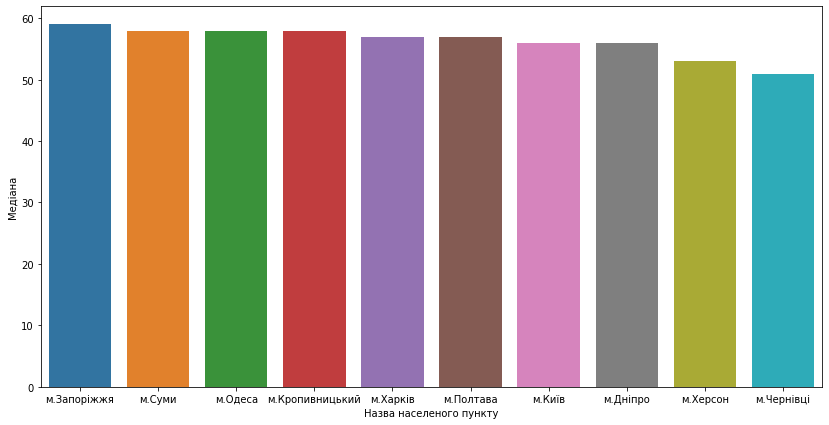

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
city_median = df_1215_city[df_1215_city.groupby(['city_name'])['city_name'].transform('size') > 1000]\
                                    .groupby(['city_name'])['call_duration_seconds'].median()
city_median.sort_values(ascending = False, inplace = True)
city_median = pd.DataFrame({'city_name':city_median.index, 'median':city_median.values})
print(city_median)
plt.figure(figsize=(14,7))
ax = sns.barplot(data = city_median.loc[:9,], x = 'city_name', y = 'median')
plt.xlabel('Назва населеного пункту')
plt.ylabel('Медіана')

9) Змініть тип даних колонки 'from_number' з str на int. Якщо потрібно, очистіть значення від зайвих символів.

In [71]:
import re
import numpy as np

df_1215_city['from_number'] = df_1215_city['from_number'].map(lambda x: np.nan if x == None else re.sub("\D", "", x))
df_1215_city['from_number'] = df_1215_city['from_number'].fillna(-1)
df_1215_city['from_number'] = df_1215_city['from_number'].astype('int64')
df_1215_city['from_number']

0                  -1
1                  -1
2        840980388592
3        840980388592
4        840980388592
             ...     
61692    386443423240
61693    894566281709
61694    693609804904
61695    935382167511
61696    590347778613
Name: from_number, Length: 61697, dtype: int64

10) Виведіть кількість унікальних вихідних номерів за типом маркетингової категорії у вигляді візуалізації, яка, на Вашу думку, найкраще тут підходить.

Text(0.5, 1.0, 'Amount of unique numbers for marketing group')

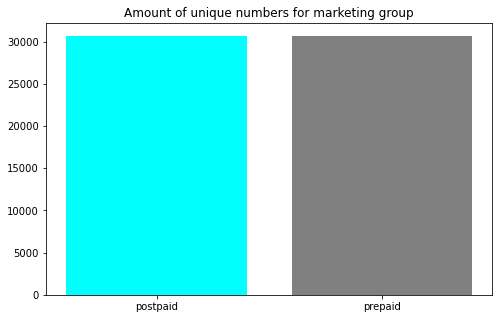

In [72]:
import collections
market_num = df_1215_city.groupby(['marketing_group'])['from_number'].unique()
x = market_num.index
len_1 = len(market_num.values.tolist()[0])
len_2 = len(market_num.values.tolist()[1])
plt.figure(figsize=(8,5))
ax = plt.bar(x,[len_1, len_2], align='center', color = ['cyan', 'gray'])
plt.title('Amount of unique numbers for marketing group')

11) Підвантажте файл systems_activity.csv з директорії datahouse<br>

<b>systems_activity.csv</b> - статистика використання мобільних систем на мережі.<br>
id - ідентифікатор мобільної системи<br>
stats_202205 - кількість годин, які система була активною з вказанням року (2022) та місяця (05)<br>
over_threshold - ознака перевищення ліміту активності системи (1-перевищення)<br>
last_update - останнє використання системи на мережі<br>

In [73]:
df_sys_act = pd.read_csv('datahouse\systems_activity.csv')
df_sys_act.tail()

,id,stats_202205,stats_202206,stats_202207,stats_202208,stats_202209,stats_202210,over_threshold,last_update
9027,UA-9027,5.48017,9.47059,12.19850,11.9727,0.0,0.0,0,2022-08-30 08:15:01
9028,UA-9028,8.78121,6.69133,8.80050,14.7760,0.0,0.0,0,2022-08-30 08:15:01
9029,UA-9029,0.00000,0.00000,0.00000,0.0000,0.0,0.0,0,2022-05-23 10:17:48
9030,UA-9030,2.97229,3.14361,3.57655,12.2962,0.0,0.0,0,2022-08-30 08:15:01
9031,UA-9031,9.93737,7.87532,13.66570,19.2880,0.0,0.0,0,2022-09-01 12:40:21


12) Виведіть динаміку загальної кількості годин використання мобільних систем по місяцям та побудуйте візуалізацію, яка, на Вашу думку, найкраще тут підходить

Text(0.5, 1.0, 'Dynamics of time of use')

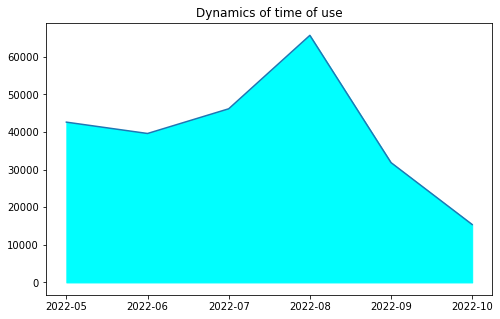

In [86]:
x = ['2022-05', '2022-06','2022-07','2022-08','2022-09','2022-10']
y = df_sys_act.iloc[:,1:7].sum().values
plt.figure(figsize=(8,5))
plt.plot(x, y)
plt.fill_between(x, y, np.zeros_like(y), color='cyan')
plt.title('Dynamics of time of use')

13) Виявіть ТОП 10 найбільш активних систем по кількості активних годин та виведіть динаміку їх використання по місяцям у вигляді візуалізації, яка, на Вашу думку, найкраще тут підходить

In [75]:
df_sys_act['sum_of_hours'] = df_sys_act.iloc[:,1:7].sum(axis = 1)

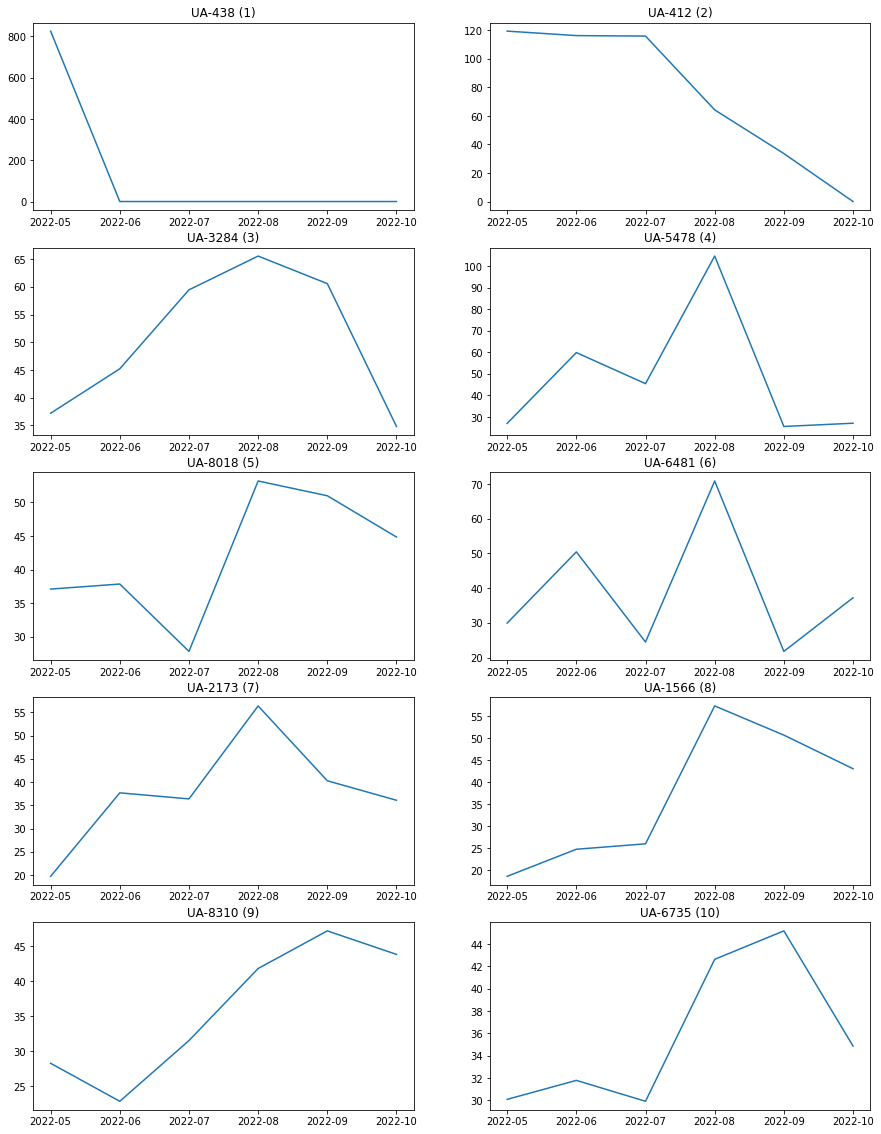

In [76]:
df_top = df_sys_act.sort_values(by = ['sum_of_hours'], ascending = False).iloc[:10]
top_sys = df_top['id'].values
dates = x.copy()
val_h = []
for i in range(0, 10):
    val_h.append(df_top.iloc[i, 1:7].values)
plt.figure(figsize=(15,20))
    
for i in range(1, 11):
    plt.subplot(5, 2, i)
    plt.plot(dates, val_h[i-1])
    plt.title(top_sys[i-1] + f' ({i})')



14) Проведіть аналіз та виявіть за якою логікою в колонці over_threshold встановлюється значення - 1

In [77]:
print('Print amount of thresholds for every month which have max hours')
for d in df_sys_act.iloc[:,1:7].columns:
    print(d, ': ', df_sys_act[df_sys_act.iloc[:,1:7].idxmax(axis=1) == d]['over_threshold'].sum())

Print amount of thresholds for every month which have max hours
stats_202205 :  8
stats_202206 :  4
stats_202207 :  5
stats_202208 :  91
stats_202209 :  74
stats_202210 :  110


Бачимо залежність порогу від розташування пікових годин, в основному на останніх місяцях. Можемо сказати що введення порогу проводиться при постійному зростанню об'єму годин по місяцях.

15) Створіть словник (dict) в якому ключ буде id системи, а значення ключа - список даних з кількістю годин за 8,9 та 10 місяць. 

In [78]:
df_dict = df_sys_act[['id', 'stats_202208', 'stats_202209', 'stats_202210']].set_index('id').T.to_dict('list')
df_dict

{'UA-0': [0.0, 0.0, 0.0],
 'UA-1': [0.0, 0.0, 0.0],
 'UA-2': [0.0, 0.0, 0.0],
 'UA-3': [0.0, 0.0, 0.0],
 'UA-4': [0.0, 0.0, 0.0],
 'UA-5': [8.43615, 1.53334, 0.0],
 'UA-6': [0.0, 0.0, 0.0],
 'UA-7': [2.38692, 0.0, 0.0],
 'UA-8': [5.29354, 4.0675099999999995, 2.8596],
 'UA-9': [0.0, 0.0, 0.0],
 'UA-10': [24.785999999999998, 5.08395, 0.0],
 'UA-11': [23.5218, 1.8705200000000002, 0.0],
 'UA-12': [35.2889, 28.9399, 38.4475],
 'UA-13': [3.6932300000000002, 1.03461, 0.0],
 'UA-14': [0.0, 0.0, 0.0],
 'UA-15': [5.99286, 4.1691199999999995, 5.41591],
 'UA-16': [1.39521, 3.34071, 3.2383900000000003],
 'UA-17': [4.402019999999999, 4.02355, 0.5182329999999999],
 'UA-18': [19.4528, 16.4923, 5.76192],
 'UA-19': [2.18708, 0.6129180000000001, 0.383251],
 'UA-20': [3.4583800000000005, 0.557733, 4.60898],
 'UA-21': [0.0, 0.0, 0.0],
 'UA-22': [9.128680000000001, 1.9223700000000001, 0.0],
 'UA-23': [13.1522, 0.8723209999999999, 1.58743],
 'UA-24': [8.72711, 10.4207, 6.387519999999999],
 'UA-25': [16.2346,

15) Напишіть функцію, яка в якості аргументу візьме значення id системи (наприклад UA-11), а поверне лише числове значення (11)

In [79]:
def id_to_num(df_id):
    return int(str(df_id)[3:])

16) Підвантажте файл calls_activity.csv з директорії datahouse<br>

<b>calls_activity.csv</b> - дані про дзвінки та їх тривалість.<br>
DATE - дата та час дзвінка<br>
ANUM - номер який здійснював дзвінок<br>
EVENT_DURATION- тривалість дзвінка в секундах<br>

In [80]:
df_calls = pd.read_csv('datahouse\calls_activity.csv', sep = ';')

17) Відфільтруйте робочий датафрейм з дзвінками так, щоб в ньому були лише номери (ANUM), які починаються з 48 та мають тривалість дзвінка більше 15 секунд

In [81]:
df_calls_f = df_calls[(df_calls["ANUM"].astype(str).str.match('48')) & (df_calls["EVENT_DURATION"] > 15)].copy()
df_calls_f.head()

,DATE,ANUM,EVENT_DURATION
0,03NOV2022:00:10:22,4872747,25
2,03NOV2022:04:45:58,4872613,115
4,03NOV2022:06:28:00,4872592,269
5,03NOV2022:06:57:54,4866545,302
7,03NOV2022:07:12:24,4866952,212


18) В відфільтрованому датафреймі створіть окрему колонку, яка відображатиме лише дату дзвінка

In [82]:
df_calls_f['DATE_DMY'] = df_calls_f['DATE'].apply(lambda x: str(x)[0:-9])
df_calls_f.head()

,DATE,ANUM,EVENT_DURATION,DATE_DMY
0,03NOV2022:00:10:22,4872747,25,03NOV2022
2,03NOV2022:04:45:58,4872613,115,03NOV2022
4,03NOV2022:06:28:00,4872592,269,03NOV2022
5,03NOV2022:06:57:54,4866545,302,03NOV2022
7,03NOV2022:07:12:24,4866952,212,03NOV2022


19) Виведіть динаміку загальної тривалості дзвінків по дням в годинах у вигляді візуалізації, яка, на Вашу думку, найкраще тут підходить.

Text(0, 0.5, 'hours')

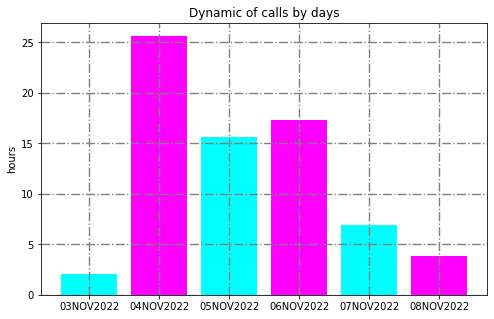

In [83]:
ser_df_calls = df_calls_f.groupby(['DATE_DMY'])['EVENT_DURATION'].sum()/3600.
plt.figure(figsize=(8,5))
ax = plt.bar(ser_df_calls.index,ser_df_calls.values, align='center', color = ['cyan', 'magenta'])
plt.grid(True, color = "grey", linewidth = "1.4", linestyle = "-.")
plt.title('Dynamic of calls by days')
plt.ylabel('hours')